In [1]:
import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

from causallearn.utils.GraphUtils import GraphUtils

In [2]:
def get_params(intercept=0.5, std=0.1):
    return {
        "1->a": intercept + np.random.normal(0, std),
        "1->b": intercept + np.random.normal(0, std),
        "1->c": intercept + np.random.normal(0, std),
        "x->a": np.random.normal(0, std),
        "y->a": np.random.normal(0, std),
        "a->b": np.random.normal(0, std),
        "j->b": np.random.normal(0, std),
        "k->b": np.random.normal(0, std),
        "b->c": np.random.normal(0, std),
    }

In [3]:
def sample_colliders_df(params=None, n=100):

    if params is None:
        params = get_params()

    independent = np.random.binomial(n=1, p=0.5, size=(n, 4))
    x, y, j, k = np.array_split(independent, 4, axis=1)

    a_prob = params["1->a"] + params["x->a"] * x + params["y->a"] * y
    a = np.random.binomial(n=1, p=a_prob, size=(n, 1))

    b_prob = params["1->b"] + params["j->b"] * j + params["k->b"] * k + params["a->b"] * a
    b = np.random.binomial(n=1, p=b_prob, size=(n, 1))

    c_prob = params["1->c"] + params["b->c"] * b
    c = np.random.binomial(n=1, p=c_prob, size=(n, 1))

    arr = np.concatenate([a, b, c, x, y, j, k], axis=1)
    df = pd.DataFrame(arr, columns="a b c x y j k".split(" "))
    return df

In [5]:
# Homework 2 synthetic data
def default_args():
    return dict(
        m_nonlinear=False,
        randomize=False,
        n=1000,

        c_var=0.02,
        a_dim=6,
        m_mean=100,
        m_var=1,

        #        C     D    A
        y_mean=[-200, -200, 4],
        y_int=200,
        y_var=1,
    )


def sample_hw2_data(**kwargs):
    """
    Sample a dataset from the given arguments.
    """

    np.random.seed(42)

    args = default_args()
    args.update(kwargs)

    m_nonlinear = args["m_nonlinear"]
    randomize = args["randomize"]
    n = args["n"]
    a_dim = args["a_dim"]

    # C is Gaussian
    c = np.random.normal(0, args["c_var"], size=[n, 1])
    # D is Binary
    d = np.random.randint(0, 2, n)

    if randomize:
        # A is fully randomized
        a = np.random.randint(0, a_dim, n)
    else:
        # Sample A conditional on C and D
        plusminus = np.power(-1, (np.arange(a_dim) < a_dim // 2).astype(int))
        probs = np.ones([1, a_dim]) / a_dim + c * plusminus
        probs = np.stack([probs for _ in range(2)], axis=1)

        thresholds = np.random.uniform(0, 1, size=[n, 2, 1])
        a = np.argmax(thresholds < np.cumsum(probs, axis=2), axis=2)
        a *= np.stack([np.ones(n, dtype=int), d], axis=1)
        a = np.max(a, axis=1)

    # Sample M conditional on A
    m_mean = args["m_mean"]
    m_var = args["m_var"]
    if m_nonlinear:
        b = (a + 1) / (1 + a_dim)
        m = np.random.normal(loc=m_mean * (1.05 * b - np.power(b, 2)),
                             scale=m_var, size=n)
    else:
        m = np.random.normal(loc=m_mean * (a + 1) / (a_dim + 1), scale=m_var, size=n)

    # Sample Y conditional on Y, C, D, and M
    c = c.reshape(n)
    y_mean = np.array(args["y_mean"])
    y = np.random.normal(np.dot(y_mean, (c, d, m)), args["y_var"])
    y += args["y_int"]

    df = pd.DataFrame(data=dict(c=c, d=d, a=a, m=m, y=y))

    return df

In [34]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge

tests = [
     "fisherz", "chisq", "gsq", 
    # "kci",  # extremely slow
    #  "mv_fisherz",  # may break
]

background = None

if False:
    background = BackgroundKnowledge()
    background.add_forbidden_by_pattern("a", "c")
    background.add_required_by_pattern("a", "b")
    background.add_required_by_pattern("b", "c")

n=10000
df = sample_colliders_df(n=n)
# df = sample_hw2_data(n=n)

for test in tests:
    print(test)
    print(df.columns)
    
    cg = pc(
        df.to_numpy(),
        indep_test=test,
        # uc_priority=3,
        background_knowledge=background,
        node_names=df.columns.tolist())
    print(cg.G)

fisherz
Index(['a', 'b', 'c', 'x', 'y', 'j', 'k'], dtype='object')


  0%|          | 0/7 [00:00<?, ?it/s]

Graph Nodes:
a;b;c;x;y;j;k

Graph Edges:
1. b --> a
2. y --> a
3. c --> b
4. j --> b
5. k --> b
6. c --- y

chisq
Index(['a', 'b', 'c', 'x', 'y', 'j', 'k'], dtype='object')


  0%|          | 0/7 [00:00<?, ?it/s]

Graph Nodes:
a;b;c;x;y;j;k

Graph Edges:
1. b --> a
2. y --> a
3. c --> b
4. j --> b
5. k --> b
6. c --- y

gsq
Index(['a', 'b', 'c', 'x', 'y', 'j', 'k'], dtype='object')


  0%|          | 0/7 [00:00<?, ?it/s]

Graph Nodes:
a;b;c;x;y;j;k

Graph Edges:
1. b --> a
2. y --> a
3. c --> b
4. j --> b
5. k --> b
6. c --- y



fisherz


  0%|          | 0/7 [00:00<?, ?it/s]

<class 'causallearn.graph.GeneralGraph.GeneralGraph'>


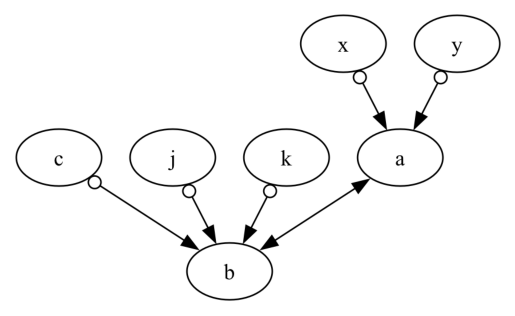

chisq


  0%|          | 0/7 [00:00<?, ?it/s]

<class 'causallearn.graph.GeneralGraph.GeneralGraph'>


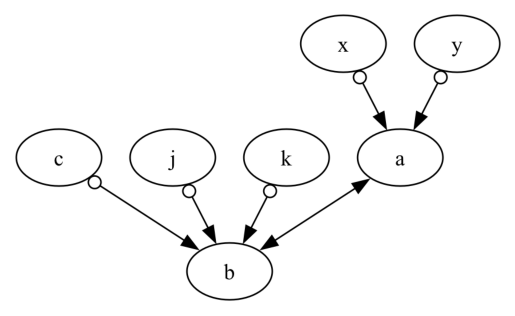

gsq


  0%|          | 0/7 [00:00<?, ?it/s]

<class 'causallearn.graph.GeneralGraph.GeneralGraph'>


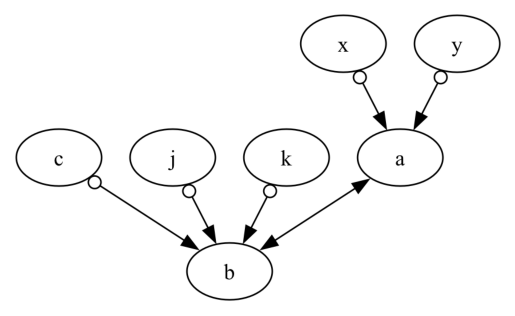

In [48]:
from causallearn.search.ConstraintBased.FCI import fci

tests = [
    "fisherz", "chisq", "gsq", # "kci", "mv_fisherz"
]

background = None

if False:
    background = BackgroundKnowledge()
    background.add_forbidden_by_pattern("a", "c")
    background.add_required_by_pattern("a", "b")
    background.add_required_by_pattern("b", "c")

n=1000000
df = sample_colliders_df(n=n)
# df = sample_hw2_data(n=n)

for test in tests:
    print(test)
    cg, edges = fci(
        df.to_numpy(),
        indep_test=test,
        alpha=0.001,
        background_knowledge=background,
        node_names=df.columns
    )
    print(type(cg))
    pyd = GraphUtils.to_pydot(cg, labels=df.columns)
    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

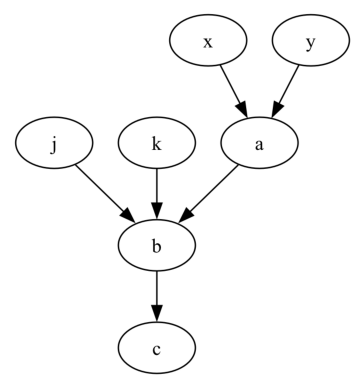

In [46]:
from causallearn.search.ScoreBased.GES import ges

n=1000000
df = sample_colliders_df(n=n)
# df = sample_hw2_data(n=n)

Record = ges(df)

pyd = GraphUtils.to_pydot(Record['G'], labels=df.columns)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()
